In [1]:
import test_config as cfg
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import os, os.path
import pickle
import io

import skimage
import skimage.io, skimage.transform, skimage.filters

import sys
sys.path.append(r'../src/')

In [2]:
import importlib
import transform
importlib.reload(transform)

<module 'transform' from '../src\\transform.py'>

In [3]:
src_fname = os.path.join(cfg.sample_path, os.listdir(cfg.sample_path)[7])
print(src_fname)
src = skimage.io.imread(src_fname, as_grey=True)

D:/Data/bujo_sample\20190309_125153.jpg


C:\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


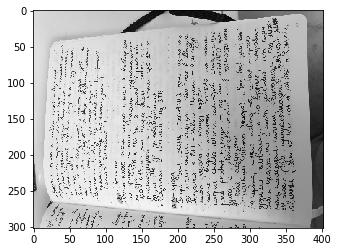

In [4]:
src2 = skimage.transform.rescale(src, scale=0.1)
plt.imshow(src2, cmap='gray')

In [5]:
res = transform.get_text_angle(src2)
print(res[0][0])

C:\Anaconda3\lib\site-packages\skimage\transform\radon_transform.py:69: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '


1.1166253101737027


C:\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


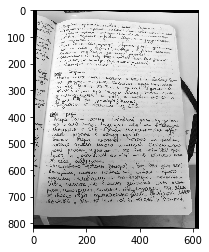

In [7]:
src3 = skimage.transform.rotate(skimage.transform.rescale(src, scale=0.2), -90.0-res[0][0], resize=True)
srcr = skimage.transform.rotate(src, -90.0-res[0][0], resize=True)
plt.imshow(src3, cmap='gray')

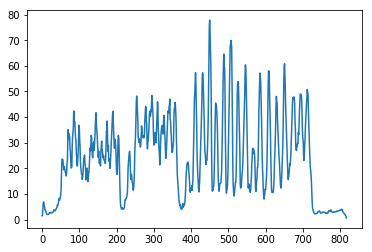

In [8]:
src3v = np.sum(np.abs(src3[:,1:]-src3[:,:-1]), axis=1)
plt.plot(src3v)

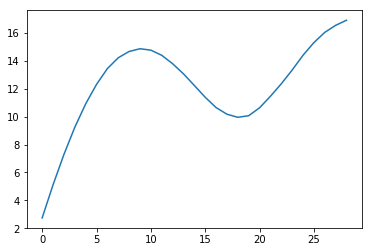

In [9]:
src4 = np.array([np.mean(np.abs(src3v[i:]-src3v[:-i])) for i in range(1, 30)])
plt.plot(src4)

In [64]:
def rolling_percentile_2d(arr, sz, q):
    res = np.zeros((sz[0]*sz[1], arr.shape[0] - sz[0] + 1, arr.shape[1] - sz[1] + 1))
    
    for i in range(sz[0]):
        for j in range(sz[1]):
            res[i*sz[1]+j, :, :] = arr[i:(arr.shape[0]-sz[0]+1+i),j:(arr.shape[1]-sz[1]+1+j)]
    
    return np.percentile(res, q, axis=0)

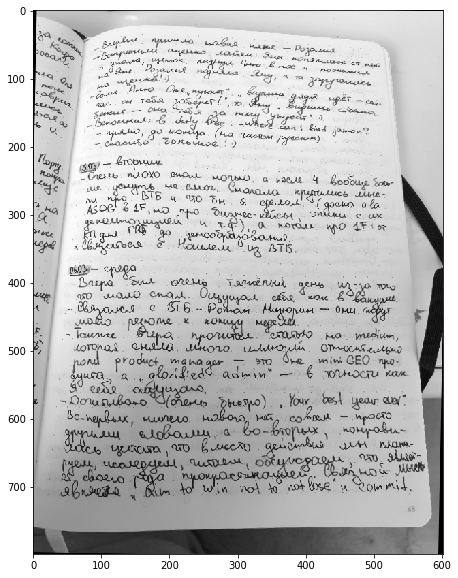

In [73]:
plt.figure(figsize=(10,10))
#plt.imshow(src3[:,15:607]-rolling_percentile_h(src3, 30, 50), cmap='gray')
plt.imshow(src3[10:-9,10:-9], cmap='gray')

In [31]:
augment_shape((12,11,10),1, 3)

((12,), 8, (10,))

In [87]:
def calc_variance_percentile_v(src, filt_sz, q):
    var = np.cumsum(np.abs(src[1:,:]-src[:-1,:]), axis=0)
    mean = (var[filt_sz[0]:,:]-var[:-filt_sz[0],:]) / filt_sz[0]
    return rolling_percentile_2d(mean, (1, filt_sz[1]), q)

def calc_variance_percentile_h(src, filt_sz, q):
    var = np.cumsum(np.abs(src[:,1:]-src[:,:-1]), axis=1)
    mean = (var[:,filt_sz[1]:]-var[:,:-filt_sz[1]]) / filt_sz[1]
    return rolling_percentile_2d(mean, (filt_sz[0], 1), q)

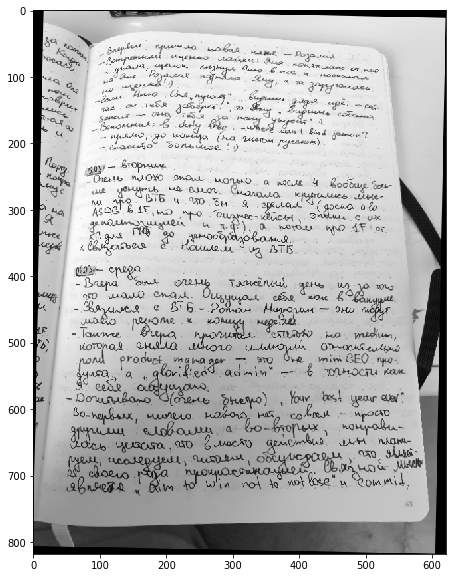

In [89]:
plt.figure(figsize=(10,10))
plt.imshow(src3, cmap='gray')

In [545]:
%%time
var_v = calc_variance_percentile_v(src3, (10,10), 50)
var_h = calc_variance_percentile_h(src3, (10,10), 50)

Wall time: 245 ms


In [546]:
tmp = var_v[:,1:-1]*var_h[1:-1,:]

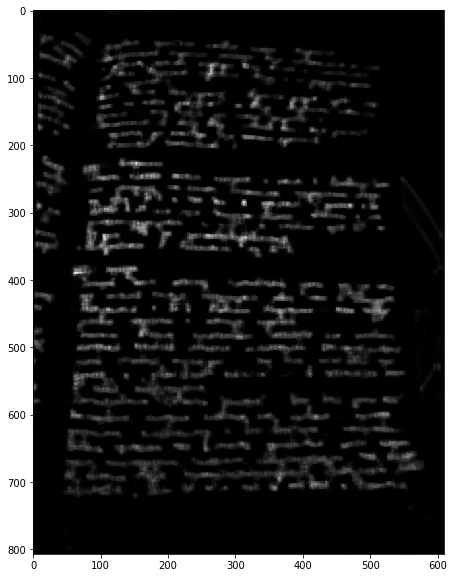

In [547]:
plt.figure(figsize=(10,10))
plt.imshow(tmp, cmap='gray')

In [127]:
def local_maxima_filter_v(src, i, d1, d2, cutoff):
    ilo1 = max(0, i-d1)
    ilo2 = max(0, i-d2)
    ihi1 = min(src.shape[0], i+d1+1)
    ihi2 = min(src.shape[0], i+d2+1)
    m1 = np.max(src[ilo1:ihi1], axis=0)
    m2 = np.max(src[ilo2:ihi2], axis=0)
    return (m1 >= m2)*(m2 > cutoff)

In [564]:
%%time
tmp2 = np.array([local_maxima_filter_v(tmp, i, 1, 10, 0.0015) for i in range(tmp.shape[0])])

Wall time: 49 ms


In [552]:
src3.shape, tmp.shape, tmp2.shape, tmp3.shape

((818, 621), (807, 610), (807, 610), (807, 610))

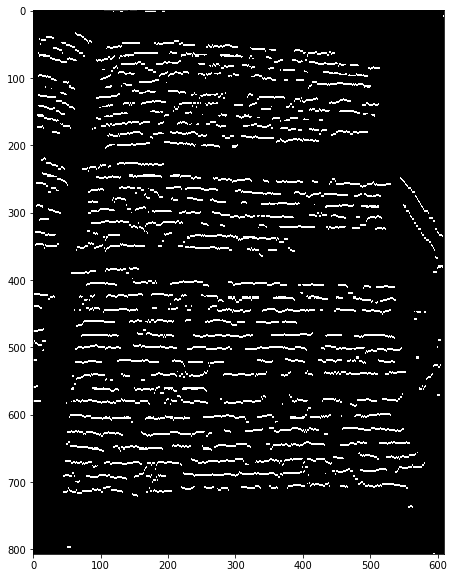

In [565]:
plt.figure(figsize=(10,10))
plt.imshow(tmp2, cmap='gray')

C:\Anaconda3\lib\site-packages\skimage\transform\radon_transform.py:69: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '


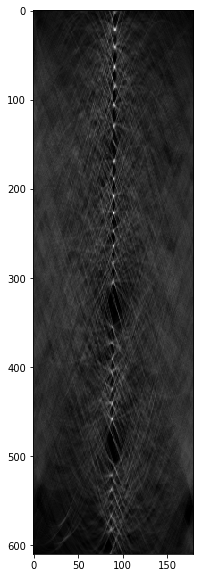

In [648]:
plt.figure(figsize=(10,10))
plt.imshow(skimage.transform.radon(tmp2, circle=True), cmap='gray')

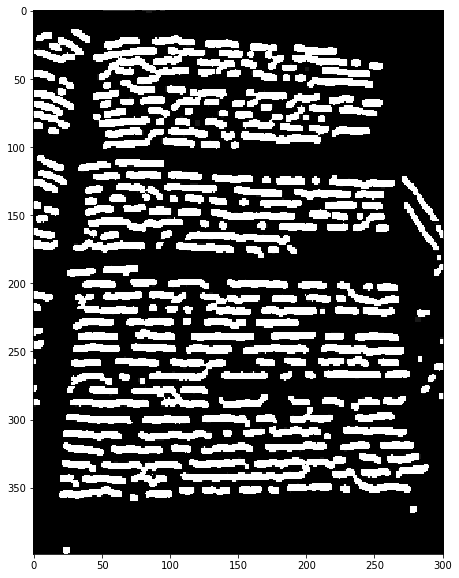

In [646]:
tmp3 = rolling_percentile_2d(tmp2, (10, 10), 90)[::2,::2]
plt.figure(figsize=(10,10))
plt.imshow(tmp3, cmap='gray')

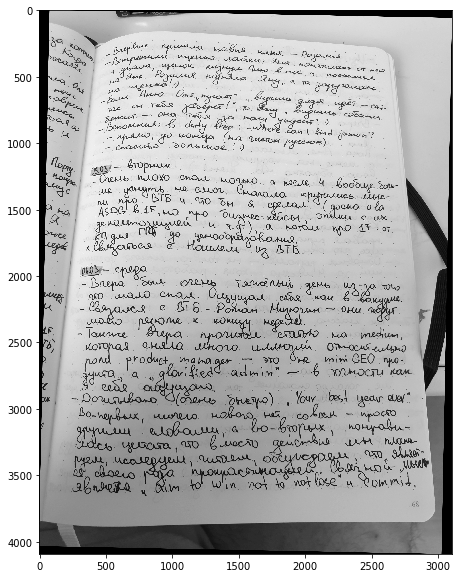

In [155]:
plt.figure(figsize=(10,10))
plt.imshow(srcr, cmap='gray')

In [183]:
def bbox_dx(src, rows, x, dxs, cutoff=0.3):
    xs = x + dxs
    xs = xs[(xs >= 0) & (xs < src.shape[1])]
    if len(xs) == 0:
        return 0
    if type(rows) in (list, np.array, np.ndarray, tuple) and np.max(rows)>np.min(rows):
        tmp = np.mean(src[np.min(rows):np.max(rows), xs], axis=0)
    else:
        tmp = src[np.min(rows), xs]
    dd = 0
    while dd < len(xs):
        if tmp[dd] < cutoff:
            return max(0, dd - 1)
        dd += 1
    return dd-1

def bbox_dy(src, cols, y, dys, cutoff=0.3):
    ys = y + dys
    ys = ys[(ys >= 0) & (ys < src.shape[0])]
    if len(ys) == 0:
        return 0
    if type(cols) in (list, np.array, np.ndarray, tuple) and np.max(cols)>np.min(cols):
        tmp = np.mean(src[ys, np.min(cols):np.max(cols)], axis=1)
    else:
        tmp = src[ys, np.min(cols)]
    dd = 0
    while dd < len(ys):
        if tmp[dd] < cutoff:
            return max(0, dd - 1)
        dd += 1
    return dd-1

def bbox_dd(src, bbox, d, vcutoff=0.3, hcutoff=0.3):
    rng = np.array(range(d+1))
    dyp = bbox_dy(src, (bbox[1], bbox[3]), np.max((bbox[0], bbox[2])), rng, vcutoff)
    dyn = bbox_dy(src, (bbox[1], bbox[3]), np.min((bbox[0], bbox[2])), -rng, vcutoff)
    dxp = bbox_dx(src, (bbox[0], bbox[2]), np.max((bbox[1], bbox[3])), rng, hcutoff)
    dxn = bbox_dx(src, (bbox[0], bbox[2]), np.min((bbox[1], bbox[3])), -rng, hcutoff)
    return (bbox[0]-dyn, bbox[1]-dxn, bbox[2]+dyp, bbox[3]+dxp)

def bbox_quality(src, bbox):
    q = np.mean(src[bbox[0]:bbox[2], bbox[1]:bbox[3]])
    q0 = np.min(np.mean(src[bbox[0]:bbox[2], bbox[1]:bbox[3]], axis=0))
    q1 = np.min(np.mean(src[bbox[0]:bbox[2], bbox[1]:bbox[3]], axis=1))
    return (q, q0, q1)

In [184]:
def find_bbox(src, i0, j0, d=10, vcutoff=0.3, hcutoff=0.3):
    bb0 = (i0, j0, i0, j0)
    bb1 = bbox_dd(src, bb0, d, vcutoff, hcutoff)
    while bb0 != bb1:
        bb0 = bb1
        bb1 = bbox_dd(src, bb0, d, vcutoff, hcutoff)
    return bb1

def find_all_bbox(src, d=10, vcutoff=0.3, hcutoff=0.3):
    res = []
    tmp = np.copy(src)
    while True:
        ind = np.argmax(tmp)
        i0 = ind // src.shape[1]
        j0 = ind % src.shape[1]
        if tmp[i0, j0] < np.max([vcutoff, hcutoff]):
            return res
        bb = find_bbox(tmp, i0, j0, d, vcutoff, hcutoff)
        if np.min([abs(bb[2]-bb[0]), abs(bb[3]-bb[1])]) == 0:
            tmp[i0, j0] = 0
        else:
            tmp[bb[0]:(bb[2]+1),bb[1]:(bb[3]+1)] = 0
            res.append(bb)
            
def plot_box(bbox, col='b'):
    x = [bbox[1], bbox[3], bbox[3], bbox[1], bbox[1]]
    y = [bbox[0], bbox[0], bbox[2], bbox[2], bbox[0]]
    plt.plot(x, y, c=col)

In [424]:
def get_combined(bbox1, bbox2, dist_h, dist_v, intersect_v):
    h1 = max(bbox1[1], bbox2[1])
    h2 = min(bbox1[3], bbox2[3])
    if h1 - h2 < dist_h:
        #print(bbox1, bbox2)
        #return None
        v1 = max(bbox1[0], bbox2[0])
        v2 = min(bbox1[2], bbox2[2])
        if v1 - v2 < dist_v:
            vd = max(bbox1[2], bbox2[2]) - min(bbox1[0], bbox2[0])
            if (v2 - v1) / vd > intersect_v:
                return (min(bbox1[0], bbox2[0]), min(bbox1[1], bbox2[1]), max(bbox1[2], bbox2[2]), max(bbox1[3], bbox2[3]))
    return None

def try_combine(bbs, dist_h, dist_v, intersect_v=0.0):
    used = np.zeros(len(bbs))
    res = []
    for i in range(len(bbs)):
        if used[i] > 0:
            continue
        for j in range(len(bbs)):
            if used[j] > 0 or i==j:
                continue
            bb = get_combined(bbs[i], bbs[j], dist_h, dist_v, intersect_v)
            if bb is not None:
                res.append(bb)
                used[i] = 1
                used[j] = 1
                break
    return res + [x for (i, x) in enumerate(bbs) if used[i]==0]

In [619]:
%%time
bbs = find_all_bbox(tmp3, vcutoff=0.01, hcutoff=0.01)

Wall time: 759 ms


In [620]:
len(bbs)

405

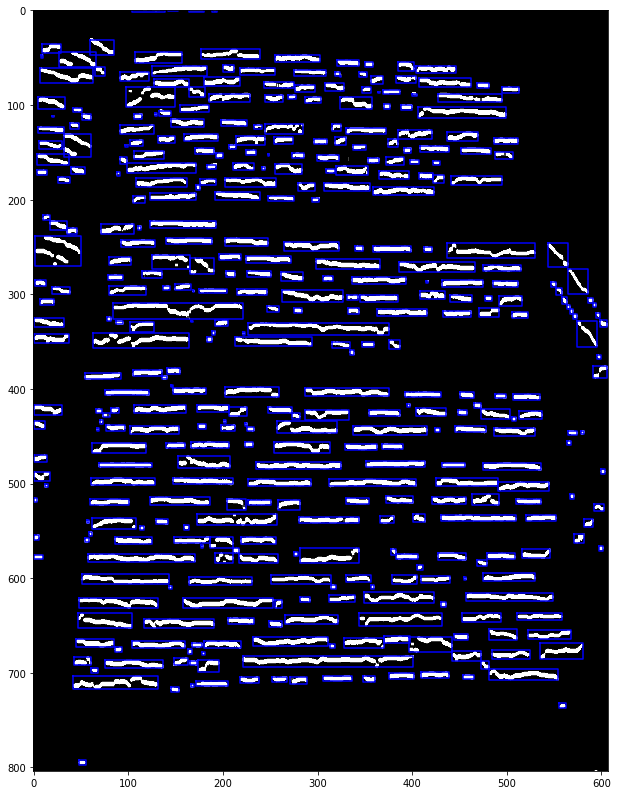

In [621]:
plt.figure(figsize=(14,14))
plt.imshow(tmp3, cmap='gray')
for bbox in bbs[:500]:
    plot_box(bbox)

In [426]:
len(bbs), len(bbs1)

(464, 403)

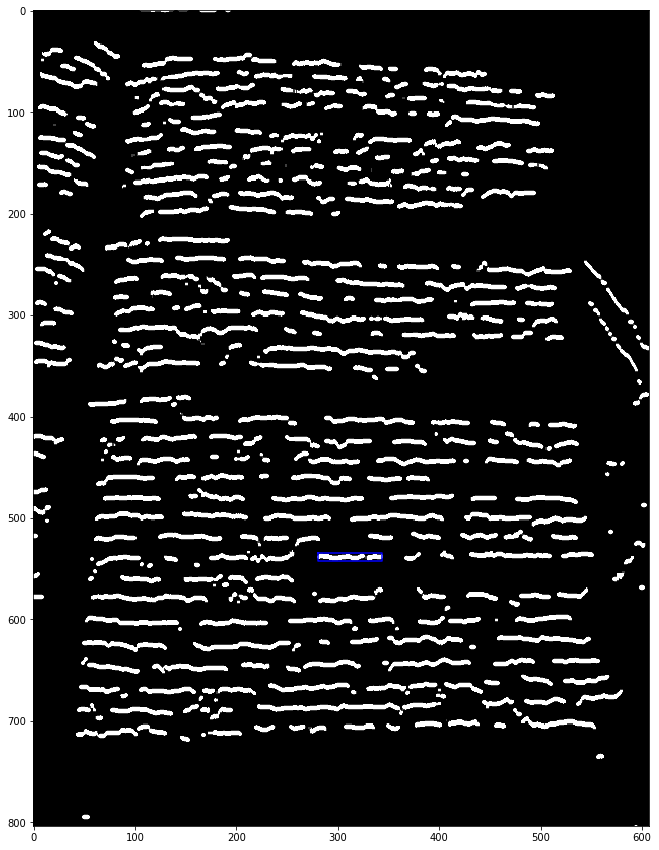

In [623]:
plt.figure(figsize=(15,15))
plt.imshow(tmp3, cmap='gray')
plot_box(bbs[300])

In [624]:
def recover_original(bbox, rolling_percentile_size, rolling_percentile_stride, var_size):
    bb = (bbox[0]*rolling_percentile_stride[0]+rolling_percentile_size[0]//2,
          bbox[1]*rolling_percentile_stride[1]+rolling_percentile_size[1]//2,
          bbox[2]*rolling_percentile_stride[0]+rolling_percentile_size[0]//2,
          bbox[3]*rolling_percentile_stride[1]+rolling_percentile_size[1]//2)
    return (bb[0]+var_size[0]//2, bb[1]+var_size[1]//2,
            bb[2]+var_size[0]//2, bb[3]+var_size[1]//2)

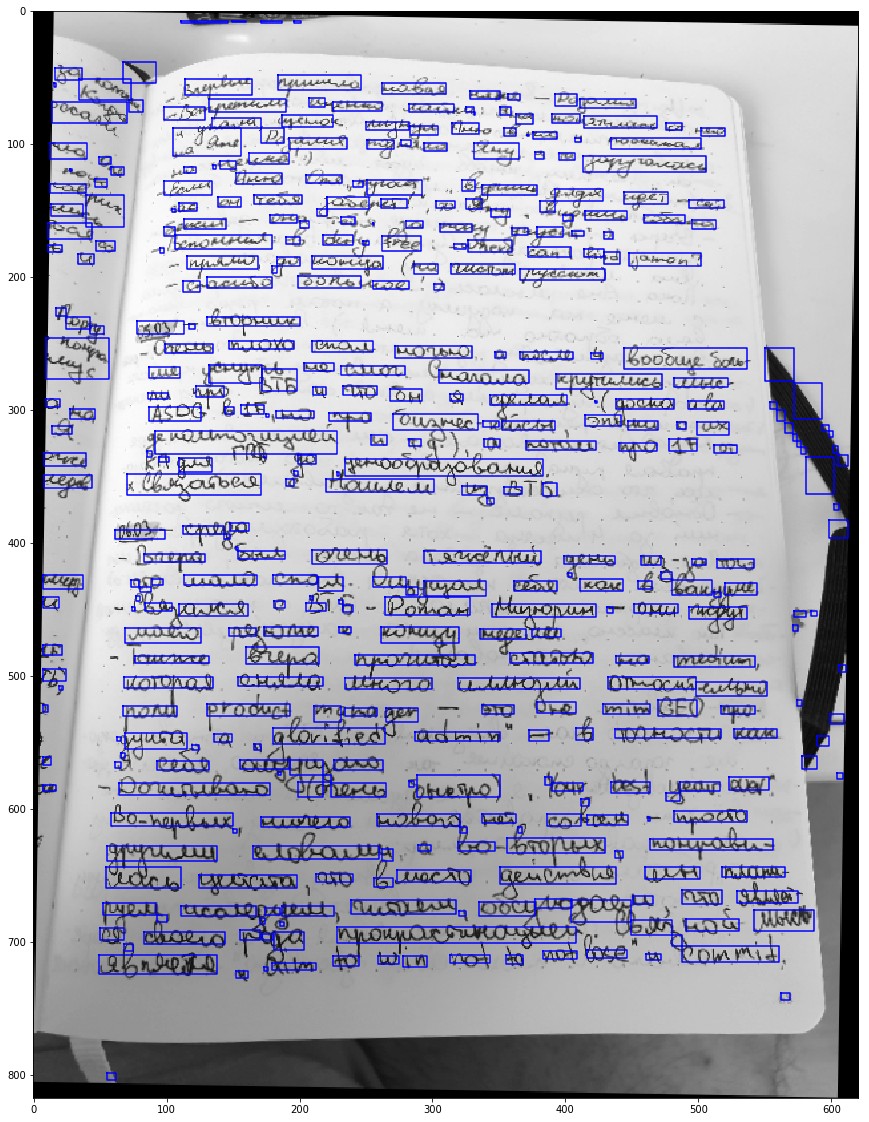

In [625]:
plt.figure(figsize=(20,20))
plt.imshow(src3, cmap='gray')
for bb in bbs:
    plot_box(recover_original(bb, (4,4), (1,1), (10,10)))